In [2]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [8]:
train = "/Users/nehasawant/Downloads/archive/seg_train/seg_train"
validation = "/Users/nehasawant/Downloads/archive/seg_test/seg_test/"

IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [9]:
train_datagen = ImageDataGenerator(rescale=1.0/255,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,fill_mode="nearest")
train_generator = train_datagen.flow_from_directory(train, target_size=(IMG_WIDTH,IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True)

Found 14034 images belonging to 6 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale= 1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation,target_size=(IMG_HEIGHT,IMG_WIDTH),batch_size=BATCH_SIZE, class_mode="categorical",shuffle=True)

Found 3000 images belonging to 6 classes.


In [11]:
labels = {value: key for key, value in train_generator .class_indices.items()}

print("lable mappings for classes presnet in the training and vlidation datasets \n")

for key, value in labels.items():
    print(f"{key} : {value}")

lable mappings for classes presnet in the training and vlidation datasets 

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


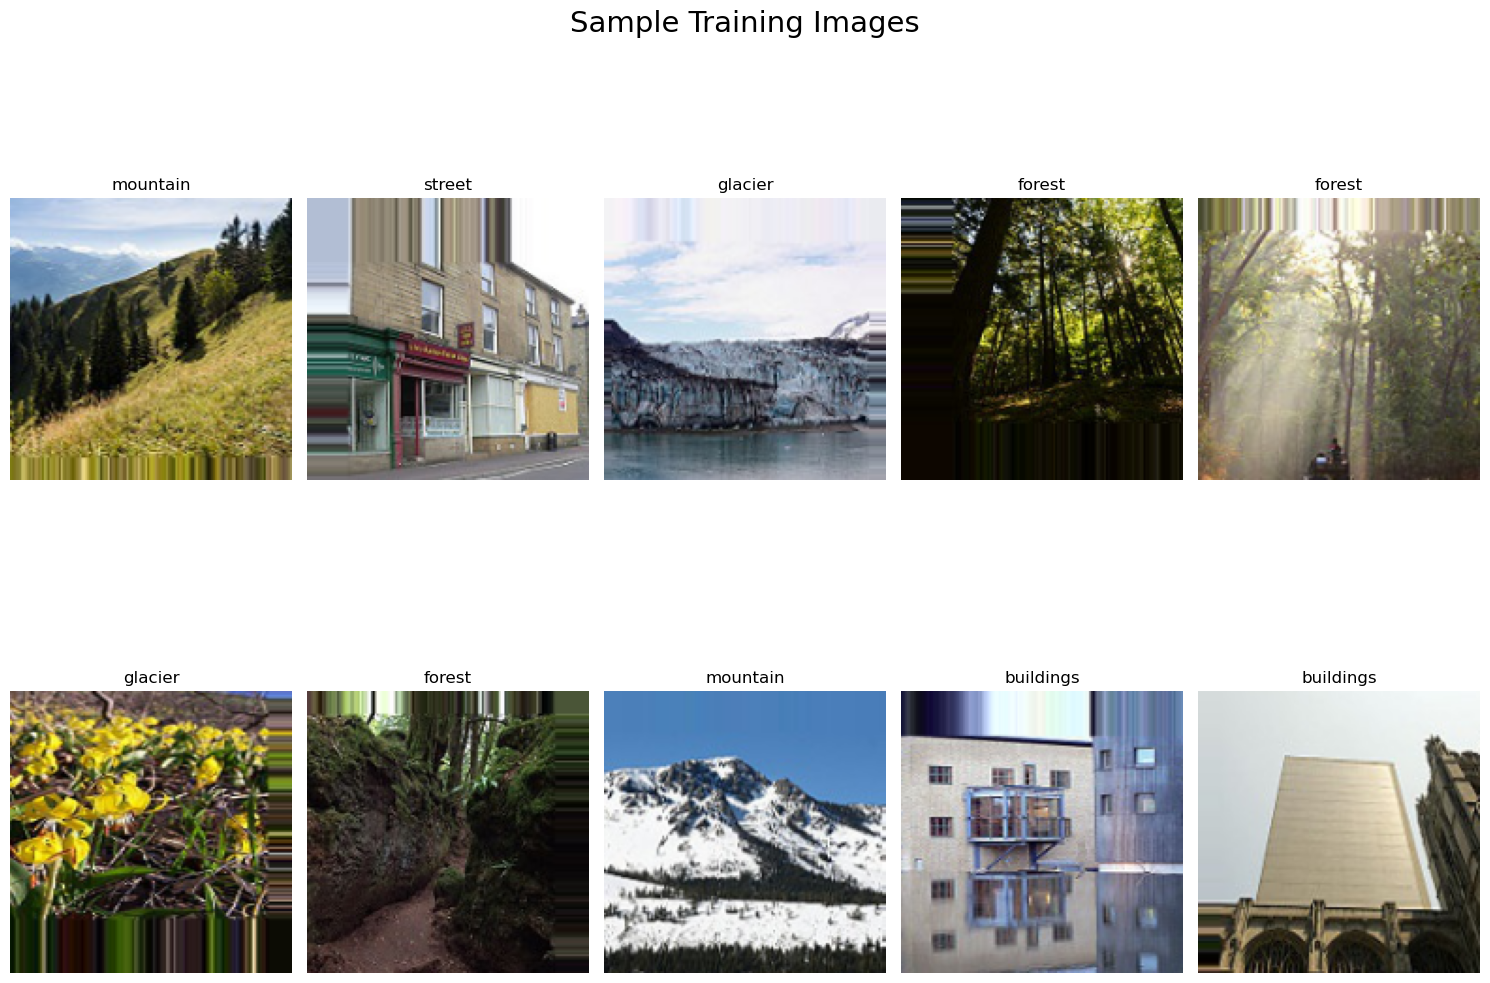

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,12))
idx = 0

for i in range(2):
    for j in range(5):
        lable = labels[np.argmax(train_generator[0][1][idx])]
        ax[i,j].set_title(f"{lable}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [13]:
def create_model():
  model = Sequential([
    Conv2D(filters=128, kernel_size=(5, 5), padding="valid", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=64, kernel_size=(3, 3), padding="valid", kernel_regularizer=l2(0.00005)),  # Fixed missing parenthesis
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(filters=32, kernel_size=(3, 3), padding="valid", kernel_regularizer=l2(0.00005)),  # Fixed missing parenthesis
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(units=256, activation="relu"),
    Dropout(0.5),
    Dense(units=6, activation="softmax")
  ])
  return model

In [14]:
cnn_model = create_model()

In [15]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 146, 146, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 71, 71, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 35, 35, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 33, 33, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,201,830 (8.40 MB)

 Trainable params: 2,201,382 (8.40 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
### reduce learning ratge on plateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [18]:
## optimizer
optimizer = Adam(learning_rate=0.001)

In [19]:
## compile the model

cnn_model.compile(optimizer=optimizer,loss=categorical_crossentropy, metrics=['accuracy'])

In [20]:
## training the model

history = cnn_model.fit(train_generator, epochs=40,validation_data=validation_generator, verbose=2, callbacks=[reduce_lr])

Epoch 1/40
439/439 - 421s - 958ms/step - accuracy: 0.5038 - loss: 1.9835 - val_accuracy: 0.5637 - val_loss: 1.1273 - learning_rate: 0.0010
Epoch 2/40
439/439 - 424s - 966ms/step - accuracy: 0.6083 - loss: 1.0810 - val_accuracy: 0.5813 - val_loss: 1.0343 - learning_rate: 0.0010
Epoch 3/40
439/439 - 431s - 981ms/step - accuracy: 0.6640 - loss: 0.9099 - val_accuracy: 0.6070 - val_loss: 1.2864 - learning_rate: 0.0010
Epoch 4/40
439/439 - 412s - 938ms/step - accuracy: 0.6967 - loss: 0.8316 - val_accuracy: 0.7230 - val_loss: 0.7995 - learning_rate: 0.0010
Epoch 5/40
439/439 - 400s - 910ms/step - accuracy: 0.7220 - loss: 0.7741 - val_accuracy: 0.7017 - val_loss: 0.8781 - learning_rate: 0.0010
Epoch 6/40
439/439 - 465s - 1s/step - accuracy: 0.7318 - loss: 0.7606 - val_accuracy: 0.7530 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 7/40
439/439 - 495s - 1s/step - accuracy: 0.7472 - loss: 0.7175 - val_accuracy: 0.7983 - val_loss: 0.5829 - learning_rate: 0.0010
Epoch 8/40
439/439 - 474s - 1s/st

In [21]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['learning_rate']

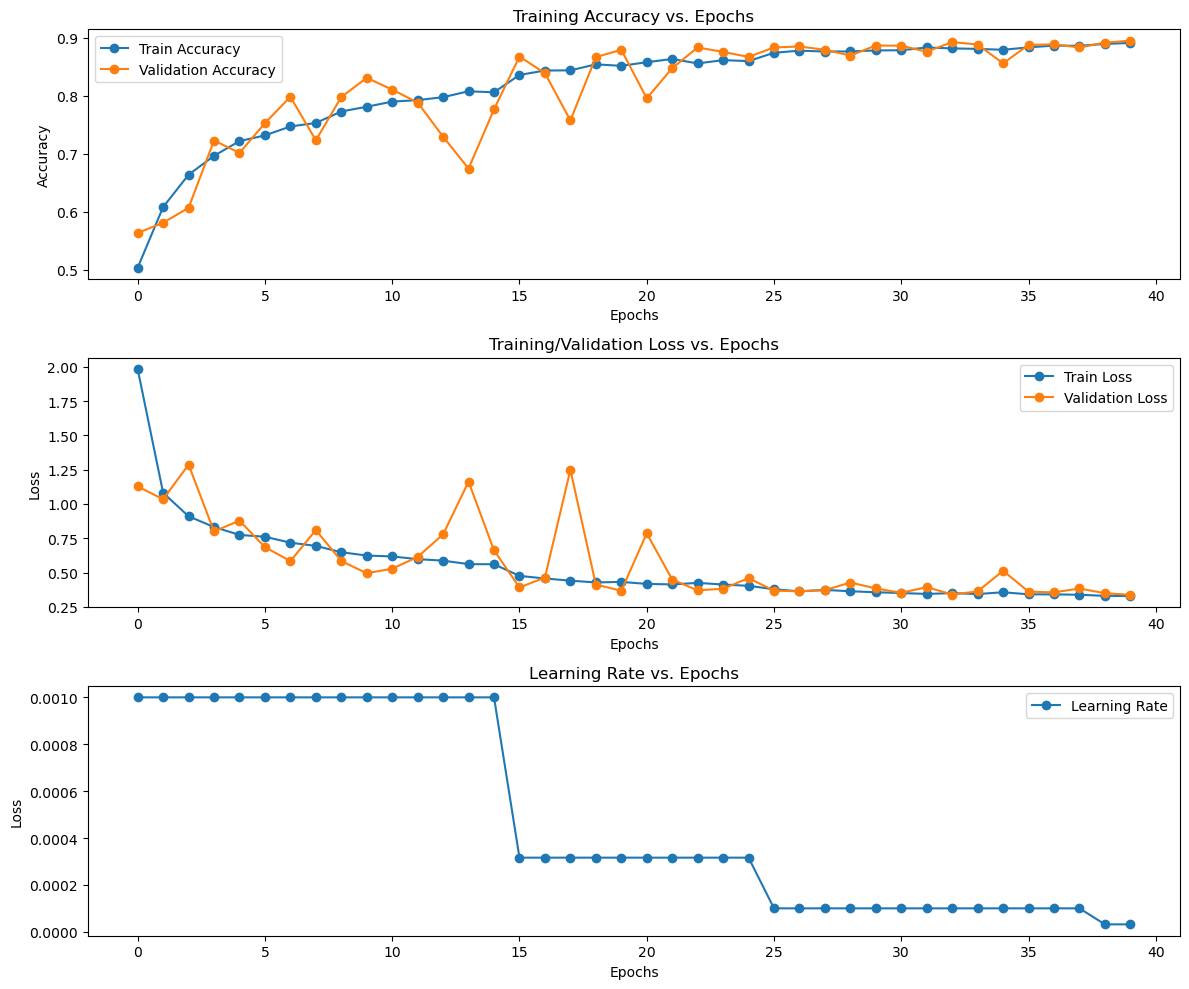

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()